In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyreadr
%matplotlib inline

In [2]:
# Import data
raw_data = pyreadr.read_r("./Data/crosssecdata.RData")['datatax']
raw_data.head()

,otu_id,count,project_id,sample_id,run_id,nreads,classification
0,107380,7.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
1,149885,1.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
2,118090,6.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
3,103181,854.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater
4,83222,1.0,MGYS00002437,SRS2822941,SRR6457279,73003.0,seawater


**otu_id**: identifies species\
**project_id**: identifies projects\
**sample_id**: identifies samples gathered within the same project\
**run_id**: same as sample_id (ansatz from some trials I've done)\
**classification**: identifies the environments from which samples are gathered\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run

For unknown reasons the dataset contains rows where count > nreads which make no sense unless I didn't interpret these quantities correctly. Maybe this number should be intended more like a normalization factor.

In his code Grilli filter the dataset by excluding sum runs entirely and also only consider data where nreads > 0 (which make sense) and where count > count_cutoff. I don't see the purpose of the cutoff on the counts so i am not doing it in my analysis.

In [3]:
# Filter the data
nreads_cutoff = 0
remove_runs = ["ERR1104477", "ERR1101508", "SRR2240575"] # bad runs filtered by Grilli
proj = raw_data[
    (raw_data['nreads'] > nreads_cutoff) & # Consider runs where at least a single species was observed
    (~raw_data['run_id'].isin(remove_runs))
]
proj = proj.copy()

# Create unique id for project and classification (treat project + classification as a single environment were samples were gathered)
proj['env_id'] = [f'{proj.loc[proj.index[i],'project_id']}_{proj.loc[proj.index[i],'classification']}' for i in range(len(proj))]
proj = proj.drop(columns=['project_id','classification','sample_id']) # here I drop also sample_id as it should have the same role of run_id

# Compute frequency and fluctuation of species in different environments
# 'f' is the empirical frequency in a single run
# 'env_f' is the average frequency of species S in environment E
# 'vf' is the empirical squared abundance fluctuation in a single run
# 'env_vf' is the variance of the frequency of species S in environment E
proj['f'] = proj['count']/proj['nreads']
proj['env_f'] = proj.groupby(['env_id', 'otu_id'], observed=True)['f'].transform('mean')
proj['vf'] = (proj['f'] - proj['env_f'])**2
proj['env_vf'] = proj.groupby(['env_id', 'otu_id'], observed=True)['vf'].transform('mean')
proj = proj.drop(columns=['count','nreads']) # drop columns not used for further analysis to keep things more compact
proj.head()

,otu_id,run_id,env_id,f,env_f,vf,env_vf
0,107380,SRR6457279,MGYS00002437_ seawater,0.000096,0.050514,0.002542,0.001237
1,149885,SRR6457279,MGYS00002437_ seawater,0.000014,0.003914,0.000015,0.000047
2,118090,SRR6457279,MGYS00002437_ seawater,0.000082,0.054376,0.002948,0.003721
3,103181,SRR6457279,MGYS00002437_ seawater,0.011698,0.074521,0.003947,0.001918
4,83222,SRR6457279,MGYS00002437_ seawater,0.000014,0.009623,0.000092,0.000095


In [4]:
# set bin edges
n_bins = 20
bin_edges = np.linspace(np.log(proj['env_f'].min()), np.log(proj['env_f'].max()), n_bins)
delta = bin_edges[1] - bin_edges[0]

# Group by the specified columns
grouped = proj.groupby(['env_id'])

# Iterate through each group and compute the histogram
histograms = {}
for env, group in grouped:

    key = str(env)[12:-3]
    entries, bins = np.histogram(np.log(group['env_f']), bins=bin_edges)
    bins = bins.tolist()
    entries = entries.tolist()
    centers = np.array([(bins[i+1] + bins[i])/2 for i in range(len(bins) - 1)])
    frequencies = np.array(entries/np.sum(entries)/delta)
    
    mu = np.sum(entries*centers)/np.sum(entries)
    std = np.sum(entries*(centers - mu)**2)/(np.sum(entries)-1)
    std = np.sqrt(np.abs(std))
    histograms[key] = {
        'bin_centers': centers,
        'frequencies': frequencies,
        'mean': mu,
        'std': std
    }

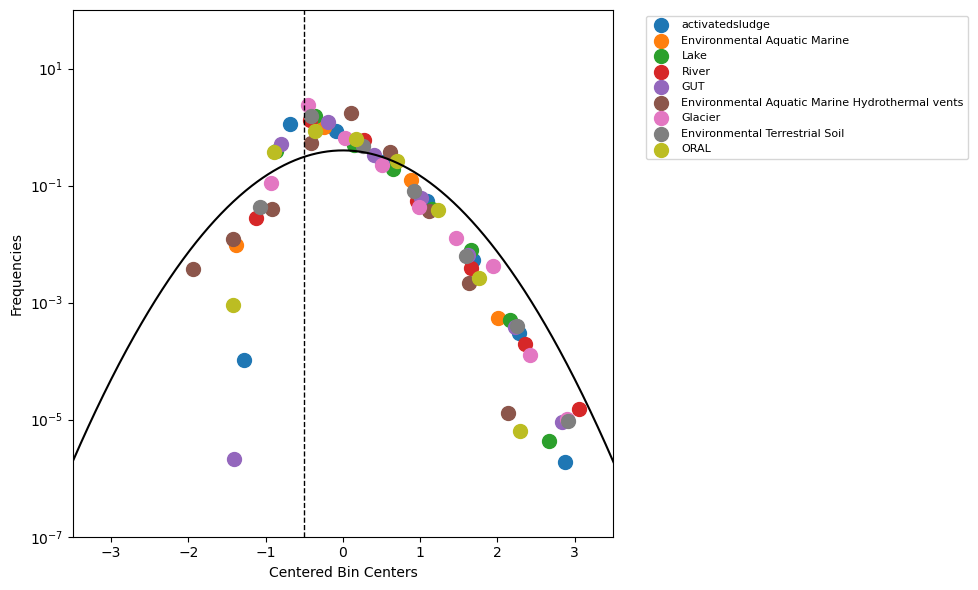

In [44]:
plt.figure(figsize=(10, 6))
    
x = np.arange(-10,10,0.01)
plt.plot(x, np.exp(-x**2)/np.sqrt(2*np.pi), c='black')

bad_envs = ['37_ seawater','feces','skin','oralcavity','VAGINAL'] # these data are way off the expected distribution
mean_std = []
for key in list(histograms.keys()):
    if key not in bad_envs:
        mask = histograms[key]['frequencies'] > 0
        mu = histograms[key]['mean']
        std = histograms[key]['std']
        x = (histograms[key]['bin_centers'][mask] - mu)/np.sqrt(2*std**2)
        y = 10**(np.log(histograms[key]['frequencies'][mask]*std*np.sqrt(np.pi/2)*2))
        plt.scatter(x, y, label=key, s=100)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 8})  # Move legend outside and set smaller size
plt.yscale('log')
plt.xlim(-3.5,3.5)
plt.ylim(1e-7,1e2)
plt.axvline(-0.5, ls='--', c='black', lw=1.0)
plt.xlabel("Centered Bin Centers")
plt.ylabel("Frequencies")
plt.tight_layout()
plt.savefig("MAD.png", dpi=300, bbox_inches="tight") 
plt.show()
